In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.operators import total_mass, total_momentum, total_energy_k, total_L2_norm
from operators.operators import solve_poisson_equation, psi_ln_sw, solve_poisson_equation_two_stream, fft_, J_matrix_inv
from operators.operators import integral_I1, integral_I2, integral_I0, linear_2_two_stream_SW
from operators.closure import closure_momentum, closure_energy

In [3]:
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib.pylab as pl
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Bump-on-Tail SW 

In [4]:
# set up configuration parameters
# number of Fourier spectral terms in x
Nx = 25
Nx_total = 2 * Nx + 1
# number of Hermite spectral terms in v
Nv = 50
# Velocity scaling of electron and ion
alpha_e1 = 1 
alpha_e2 = np.sqrt(1 / 2)
alpha_i = np.sqrt(1 / 1836)
# perturbation magnitude
epsilon = 0.03
# x grid is from 0 to L
L = 20 * np.pi / 3
# final time
T =10
# time stepping
dt = 0.01
# time vector
t_vec = np.linspace(0, T, int(T / dt) + 1)
# velocity scaling
u_e1 = -1
u_e2 = 4.5
u_i = -1
# mass normalized
m_e1 = 1
m_e2 = 1
m_i = 1836
# charge normalized
q_e1 = -1
q_e2 = -1
q_i = 1

In [5]:
# inverse J
J_inv = J_matrix_inv(Nx=Nx, L=L)

In [6]:
# velocity grid for plotting purposes
v = np.linspace(-5, 8, int(1e3))
# spatial grid 
x_project = np.linspace(0, L, int(1e5))
x = np.linspace(0, L, Nx_total)

## read in simulation results

In [7]:
sol_midpoint_u = np.load("../data/SW/bump_on_tail/sol_midpoint_u_" + str(Nv) + "_energy_closure.npy")[:, ::10]
sol_midpoint_t = np.load("../data/SW/bump_on_tail/sol_midpoint_t_" + str(Nv) + "_energy_closure.npy")[::10]
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(7656, 51)
(51,)


In [8]:
# initialize the electric potential
E_midpoint = np.zeros((Nx_total, len(sol_midpoint_t)), dtype="complex128")

In [9]:
# initialize the states for implicit midpoint (symplectic)
state_e1_midpoint = np.zeros((Nv, Nx_total, len(sol_midpoint_t)), dtype="complex128")
state_e2_midpoint = np.zeros((Nv, Nx_total, len(sol_midpoint_t)), dtype="complex128")
state_i_midpoint = np.zeros((Nv, Nx_total, len(sol_midpoint_t)), dtype="complex128")

closure_e1 = np.zeros((Nx_total, len(sol_midpoint_t)), dtype="complex128")
closure_e2 = np.zeros((Nx_total, len(sol_midpoint_t)), dtype="complex128")
closure_i = np.zeros((Nx_total, len(sol_midpoint_t)), dtype="complex128")
for ii in range(len(sol_midpoint_t)):
    for jj in range(Nv):
        # unwind the flattening in order to solve the linear system
        state_e1_midpoint[jj, :, ii] = sol_midpoint_u[jj * Nx_total: (jj + 1) * Nx_total, ii]
        state_e2_midpoint[jj, :, ii] = sol_midpoint_u[Nv * Nx_total + jj * Nx_total: Nv * Nx_total + (jj + 1) * Nx_total, ii]
        state_i_midpoint[jj, :, ii] = sol_midpoint_u[2 * Nv * Nx_total + jj * Nx_total: 2* Nv * Nx_total + (jj + 1) * Nx_total, ii]

    E_midpoint[:, ii] = solve_poisson_equation_two_stream(state_e1=state_e1_midpoint[:, :, ii],
                                                          state_e2=state_e2_midpoint[:, :, ii],
                                                          state_i=state_i_midpoint[:, :, ii],
                                                          alpha_e1=alpha_e1, alpha_e2=alpha_e2, alpha_i=alpha_i,
                                                          Nx=Nx, L=L,  Nv=Nv)
    # energy closure
    closure_e1 = closure_energy(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, u_s=u_e1, Nv=Nv, E=E_midpoint[:, ii], J_inv=J_inv, q_s=q_e1, m_s=m_e1, Nx_total=Nx_total)
    closure_e2 = closure_energy(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, u_s=u_e2, Nv=Nv, E=E_midpoint[:, ii], J_inv=J_inv, q_s=q_e2, m_s=m_e2, Nx_total=Nx_total)
    closure_i = closure_energy(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, u_s=u_i, Nv=Nv, E=E_midpoint[:, ii], J_inv=J_inv, q_s=q_i, m_s=m_i, Nx_total=Nx_total)

    # # momentum closure
    # closure_e1 = closure_momentum(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, u_s=u_e1, Nv=Nv)
    # closure_e2 = closure_momentum(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, u_s=u_e2, Nv=Nv)
    # closure_i = closure_momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, u_s=u_i, Nv=Nv)

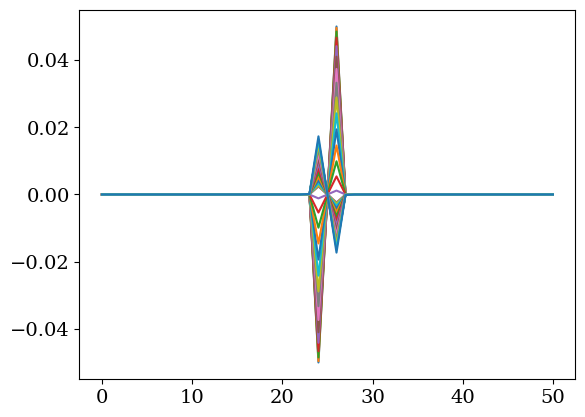

In [10]:
_  = plt.plot(E_midpoint[:, :].imag)

In [11]:
E_field = np.zeros(np.shape(E_midpoint))
for ii in range(len(sol_midpoint_t)):
    E_field[:, ii] = fft_(E_midpoint[:, ii], Nx, x, L)

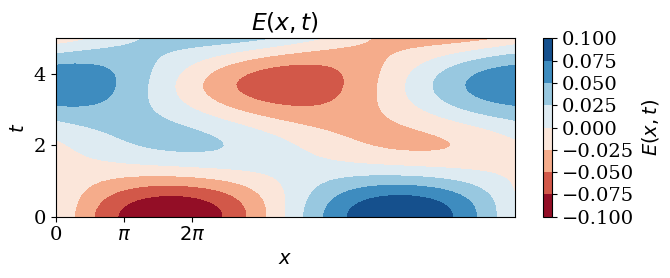

In [12]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.contourf(x, sol_midpoint_t, E_field.T, cmap="RdBu")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

plt.savefig("../figs/SW/bump_on_tail/electric_field_SW_sqrt.png", dpi=600)

In [13]:
E1_midpoint = np.zeros(len(sol_midpoint_t))


for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(E_midpoint[Nx+1, ii])

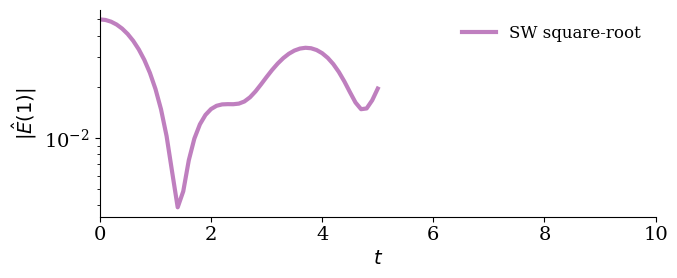

In [14]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "-", c="purple", alpha=0.5, linewidth=3, label="SW square-root") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/damping_rate_electric_field.png", dpi=600)

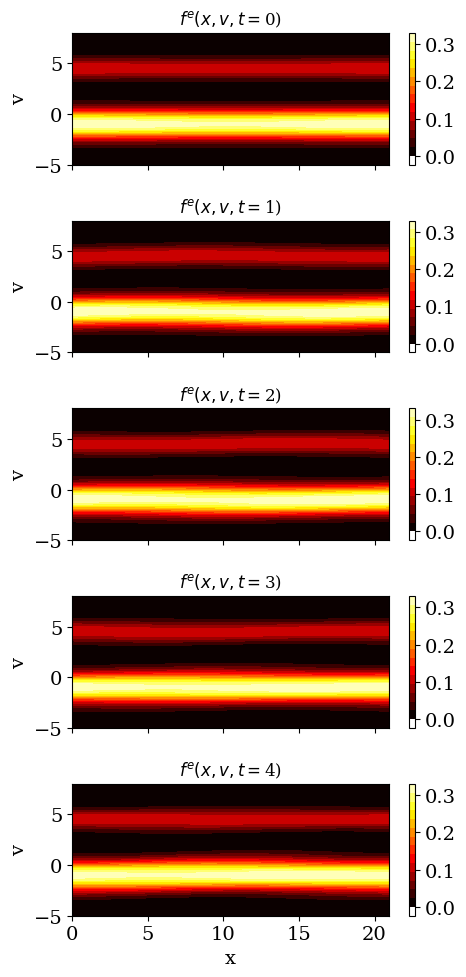

In [15]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(5, 10))
for tt, ii in enumerate(range(0, len(sol_midpoint_t), int(len(sol_midpoint_t)//4))):
    distribution1 = np.zeros((2*Nx+1, len(v)))
    distribution2 = np.zeros((2*Nx+1, len(v)))
    for jj in range(Nv):
        distribution1 += np.outer(fft_(state_e1_midpoint[jj, :, ii], Nx, x, L), psi_ln_sw(xi=(v-u_e1)/alpha_e1, v=v, u_s=u_e1, alpha_s=alpha_e1, n=jj)).real
        distribution2 += np.outer(fft_(state_e2_midpoint[jj, :, ii], Nx, x, L), psi_ln_sw(xi=(v-u_e2)/alpha_e2, v=v, u_s=u_e2, alpha_s=alpha_e2, n=jj)).real
        
    levels = np.append(-0.1, np.linspace(0, 0.33, 15))
    colors = mcp.gen_color(cmap="hot",n=len(levels)-1)
    pos = ax[tt].contourf(x, v, (distribution1 + distribution2).T, levels=levels, colors=np.append(["w"], colors))
    #ax[tt].set_xticks([0, 5*np.pi, 10*np.pi, 15*np.pi, 20*np.pi])
    #ax[tt].set_xticklabels([r"0", r"$5\pi$", r"$10\pi$", r"$15\pi$", r"$20\pi$"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")", fontsize=12)
ax[-1].set_xlabel("x")
plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/bump_on_tail_evolution_SW.png", dpi=600)

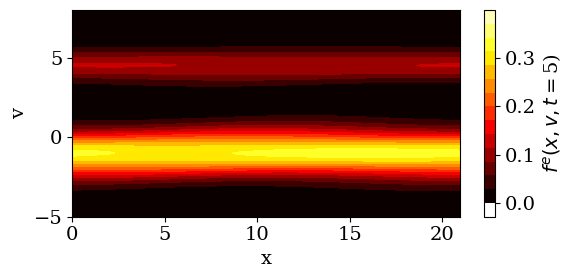

In [16]:
fig, ax = plt.subplots(figsize=(6, 3))

ii = -1

distribution1 = np.zeros((2*Nx+1, len(v)))
distribution2 = np.zeros((2*Nx+1, len(v)))

for jj in range(Nv):
    distribution1 +=  np.outer(fft_(state_e1_midpoint[jj, :, ii], Nx, x, L), psi_ln_sw(xi=(v-u_e1)/alpha_e1, v=v, alpha_s=alpha_e1, u_s=u_e1, n=jj)).real
    distribution2 +=  np.outer(fft_(state_e2_midpoint[jj, :, ii], Nx, x, L), psi_ln_sw(xi=(v-u_e2)/alpha_e2, v=v, alpha_s=alpha_e2, u_s=u_e2, n=jj)).real
    
levels = np.append(-0.1, np.linspace(0, 0.4, 15))
colors = mcp.gen_color(cmap="hot",n=len(levels)-1)
pos = ax.contourf(x, v, (distribution1 + distribution2).T, levels=levels, colors=np.append(["w"], colors))
ax.set_xlabel("x")
ax.set_ylabel("v")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])
plt.tight_layout()
plt.savefig("../figs/SW/bump_on_tail/bump_on_tail_electron_distribution_t_20_SW_sqrt.png", dpi=600)

# Conservation Laws

### mass conservation 

In [17]:
mass_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, L=L, Nv=Nv, Nx=Nx)\
                      + total_mass(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, L=L, Nv=Nv, Nx=Nx)\
                      + total_mass(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, L=L, Nv=Nv, Nx=Nx)

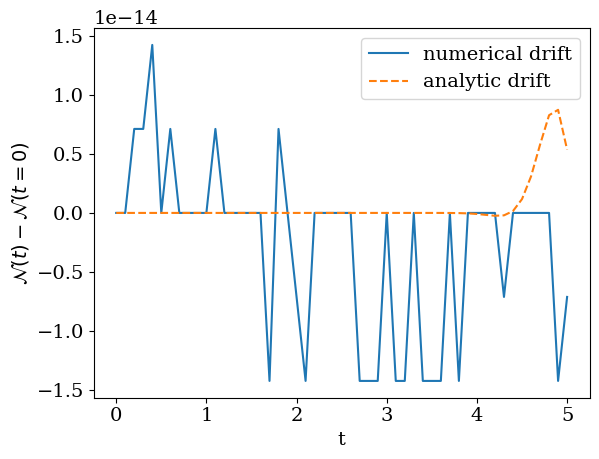

In [18]:
plt.plot(sol_midpoint_t, np.real(mass_midpoint - mass_midpoint[0]), label="numerical drift")
plt.plot(sol_midpoint_t, np.real(sol_midpoint_u[-2]).real, ls="--", label="analytic drift")
plt.ylabel(r"$\mathcal{N}(t)-\mathcal{N}(t=0)$")
plt.xlabel("t")
#plt.yscale("log")
plt.legend()

### momentum conservation

In [19]:
momentum_midpoint_e1 = np.zeros(len(sol_midpoint_t), dtype="complex128")
momentum_midpoint_e2 = np.zeros(len(sol_midpoint_t), dtype="complex128")
momentum_midpoint_i = np.zeros(len(sol_midpoint_t), dtype="complex128")
momentum_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint_e1[ii] = total_momentum(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, L=L, Nv=Nv, m_s=m_e1, u_s=u_e1, Nx=Nx)
    momentum_midpoint_e2[ii] = total_momentum(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, L=L, Nv=Nv, m_s=m_e2, u_s=u_e2, Nx=Nx)
    momentum_midpoint_i[ii] =  total_momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, L=L, Nv=Nv, m_s=m_i, u_s=u_i, Nx=Nx)             
    
    momentum_midpoint[ii] = momentum_midpoint_e1[ii]+ momentum_midpoint_e2[ii]+ momentum_midpoint_i[ii]

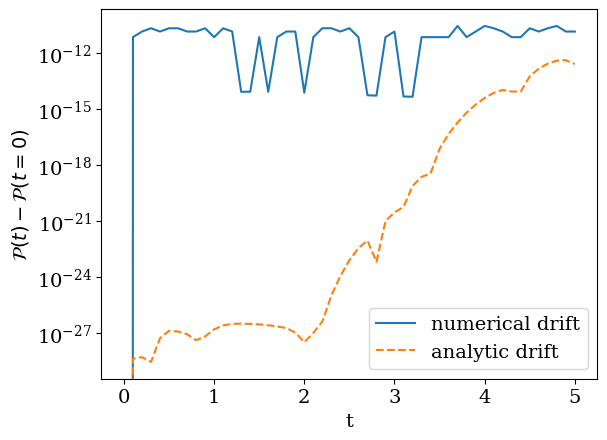

In [20]:
#plt.plot(sol_midpoint_t, np.abs(momentum_midpoint_i))
plt.plot(sol_midpoint_t, np.abs(momentum_midpoint-momentum_midpoint[0]), label="numerical drift")
plt.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-4]), ls="--", label="analytic drift")
plt.ylabel(r"$\mathcal{P}(t)-\mathcal{P}(t=0)$")
plt.xlabel("t")
plt.yscale("log")
plt.legend()

### energy conservation

In [21]:
energy_k_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")
energy_p_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, L=L, Nv=Nv, m_s=m_e1, u_s=u_e1, Nx=Nx)\
                            + total_energy_k(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, L=L, Nv=Nv, m_s=m_e2, u_s=u_e2, Nx=Nx)\
                            + total_energy_k(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, L=L, Nv=Nv, m_s=m_i, u_s=u_i, Nx=Nx)

    energy_p_midpoint[ii] = 0.5 * L * np.flip(E_midpoint[:, ii]).T @ E_midpoint[:, ii]

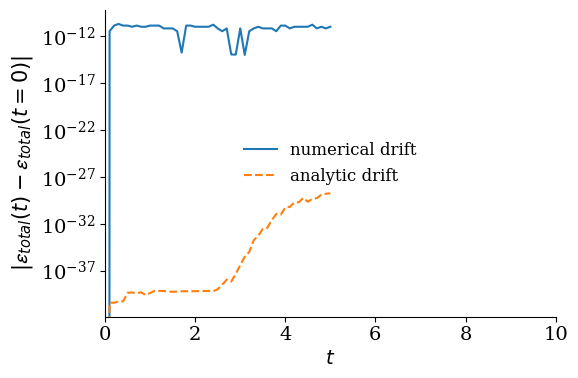

In [22]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), label="numerical drift")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-6]), ls="--", label="analytic drift")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='center')
legend.get_frame().set_alpha(0)
plt.tight_layout()

$L^{2}$ norm

In [30]:
L2_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    L2_midpoint[ii] = total_L2_norm(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, L=L, Nv=Nv)\
                     +total_L2_norm(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, L=L, Nv=Nv)\
                     +total_L2_norm(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, L=L, Nv=Nv)

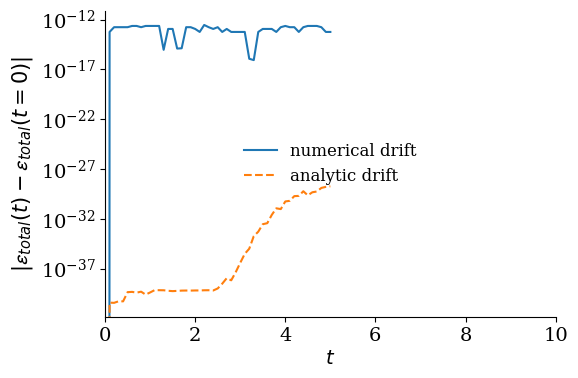

In [31]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.plot(sol_midpoint_t, np.abs(L2_midpoint-L2_midpoint[0]), label="numerical drift")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-6]), ls="--", label="analytic drift")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='center')
legend.get_frame().set_alpha(0)
plt.tight_layout()

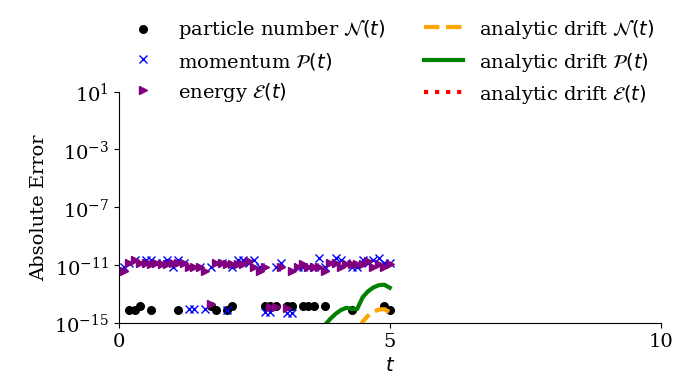

In [24]:
# plot overall conservation properties 
fig, ax = plt.subplots(ncols=1, figsize=(7, 3))
ax.scatter(sol_midpoint_t, np.abs(mass_midpoint-mass_midpoint[0]), s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint-momentum_midpoint[0]), "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-2]), "--", c="orange", linewidth=3, label=r"analytic drift $\mathcal{N}(t)$ ")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-4]), "-", c="green", linewidth=3, label=r"analytic drift $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-6]), ":", c="red", linewidth=3, label=r"analytic drift $\mathcal{E}(t)$")
ax.set_ylim(10**-15, 10**1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.4))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW/bump_on_tail/conservation_" + str(Nv) + "_bump_on_tail_SW_energy.png", bbox_inches='tight', dpi=600)